## Notebook used to calculate spectrum of $\Phi$ values using PyPhi wrapper

In [1]:
import pyphi
import numpy as np
from pyphi import phi_spectrum
from pyphi import utils
# from pyphi.phi_spectrum import get_all_CES

# Transition probability matrix. Saying where each state goes (little-endian notation)
tpm = np.array([
    [0.,0.,0.],
    [0.,0.,0.],
    [1.,0.,0.],
    [1.,0.,1.],
    [0.,1.,0.],
    [0.,1.,0.],
    [1.,1.,0.],
    [1.,1.,1.]
])

# Set up network object
network = pyphi.Network(tpm, node_labels=['R','C','P'])
print("Network = ",network.node_labels)

# Put the system into a given state
state = (0,0,0)
nodes = ['R','C','P']

## Get the requisite Subsystem
subsystem = pyphi.Subsystem(network, state, nodes)

## Calculate all Phi values
display_CES= False  # if True, output will display constellations
Phi_Spectrum = phi_spectrum.get_phi_spectrum(subsystem,display_CES)

print("\nCuts = ",Phi_Spectrum[0])
print("\nPhi Spectrum = ",Phi_Spectrum[1])


Network =  NodeLabels(('R', 'C', 'P'))
	Number of Non-unique Constellations = 3

Evaluating Cut  Cut [R] ━━/ /━━➤ [C, P]
	Number of Non-unique Constellations = 1
	Phi Values for Cut =  [0.243056, 0.1875, 0.215278]

Evaluating Cut  Cut [C] ━━/ /━━➤ [R, P]
	Number of Non-unique Constellations = 1
	Phi Values for Cut =  [0.6875, 0.743055, 0.715277]

Evaluating Cut  Cut [R, C] ━━/ /━━➤ [P]
	Number of Non-unique Constellations = 1
	Phi Values for Cut =  [0.298611, 0.298611, 0.326389]

Evaluating Cut  Cut [P] ━━/ /━━➤ [R, C]
	Number of Non-unique Constellations = 1
	Phi Values for Cut =  [0.611111, 0.611111, 0.638889]

Evaluating Cut  Cut [R, P] ━━/ /━━➤ [C]
	Number of Non-unique Constellations = 1
	Phi Values for Cut =  [0.611111, 0.611111, 0.638889]

Evaluating Cut  Cut [C, P] ━━/ /━━➤ [R]
	Number of Non-unique Constellations = 3
	Phi Values for Cut =  [0.625, 0.680555, 0.652777, 0.680555, 0.625, 0.652777, 0.652777, 0.652777, 0.625]

Cuts =  [Cut [R] ━━/ /━━➤ [C, P], Cut [C] ━━/ /━━➤ [R, P

#### Get Phi MIP (i.e. all phi values between the min and max value of the MIP)

In [6]:
Phi_MIP = phi_spectrum.get_Phi_MIP(Phi_Spectrum)
print("Phi MIP = ",Phi_MIP)

Phi MIP =  [0.1875   0.215278 0.243056]


## Figures

#### First we need to find a font that renders the cut symbol correctly

In [2]:
from fontTools.ttLib import TTFont
import matplotlib.font_manager as mfm

## Choose a font that renders the cut symbol properly
def char_in_font(Unicode_char, font):
    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(Unicode_char) in cmap.cmap:
                return True
    return False


uni_char = "\u27A4"

font_info = [(f.fname, f.name) for f in mfm.fontManager.ttflist]
for i, font in enumerate(font_info):
    if char_in_font(uni_char, TTFont(font[0], fontNumber=0)):
        print(font[0], font[1])

/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf DejaVu Sans
/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf DejaVu Sans
/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf DejaVu Sans Mono
/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf DejaVu Sans
/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf DejaVu Sans
/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf DejaVu Sans Mono


FileNotFoundError: [Errno 2] No such file or directory: '/Library/Fonts/InaiMathi.ttf'

#### Now Plot

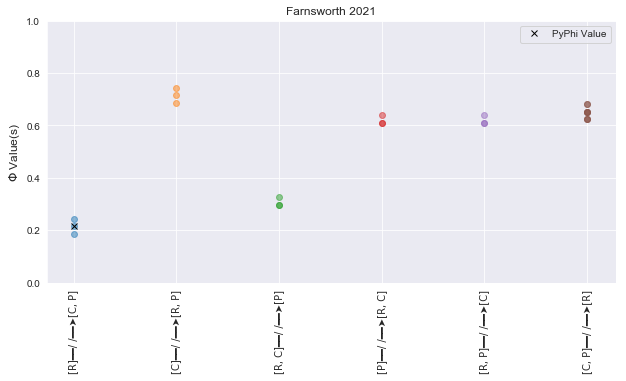

In [3]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import seaborn as sns
from pyphi import models
sns.set_style('darkgrid')
%matplotlib inline

## UTF Characters
LINE = "\u2501"
CUT_SYMBOL = LINE * 2 + "/ /" + LINE * 2 + "\u27A4"

## Set Font
font_path = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
# font_path = '/Users/jakehanson/.brew/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
font = mfm.FontProperties(fname=font_path) # find this font

## Initialize fig, ax objects
fig = plt.figure(figsize=(8.8,5.4))
ax = plt.subplot(111)

## Scatterplot Phi Values for each cut
x_labels = []
for i in range(len(Phi_Spectrum[0])):
    cut = Phi_Spectrum[0][i]
    
    ## Get label for cut
    from_nodes = models.fmt.fmt_mechanism(cut.from_nodes, cut.node_labels)
    to_nodes = models.fmt.fmt_mechanism(cut.to_nodes, cut.node_labels)
    cut_label = from_nodes+CUT_SYMBOL+to_nodes
    
    ## Plot
    plt.scatter([i]*len(Phi_Spectrum[1][i]),Phi_Spectrum[1][i],alpha=0.5)
    x_labels.append(cut_label)
    
plt.title('Farnsworth 2021')
plt.ylabel(r'$\Phi$ Value(s)',fontsize=12)
plt.plot([0],[0.2153],'kx',label='PyPhi Value')
plt.xticks(range(len(Phi_Spectrum[0])),x_labels,rotation=90,fontproperties=font)
plt.ylim((0.0,1.0))
plt.legend()
# plt.legend(ncol=1,bbox_to_anchor = [1.25,1.0],prop=font,fontsize=12)
plt.tight_layout()
plt.savefig("Preliminary_Plot.pdf")
plt.show()